In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import proxy_crm_modules as pCRM
import numpy as np

In [2]:
data_src = "D:/crmProject/dataSamples/pywaterflood-master/testing/data/"
prod = pd.read_csv(data_src + "production.csv", header= None)
inj = pd.read_csv(data_src + "injection.csv", header=None)
time = pd.read_csv(data_src + "time.csv", header= None)

train_size = int(0.75 * prod.shape[0])

In [3]:
time.head()

,0
0,30.99
1,58.99
2,89.99
3,119.99
4,150.99


In [4]:
prod_shut_in = pd.read_csv(data_src + "production.csv", header= None)

# Get the column as a NumPy array
column_val = prod_shut_in[3].to_numpy()

# Pad the array with zeros at the beginning
i = len(prod_shut_in)//2
padded_val = np.insert(column_val, i, np.zeros(20))
prod_shut_in[3] = padded_val[:len(prod_shut_in[3])]

In [5]:
inj_shut_in = pd.read_csv(data_src + "injection.csv", header= None)

# Get the column as a NumPy array
column_val_i3 = inj_shut_in[2].to_numpy()
column_val_i4 = inj_shut_in[3].to_numpy()
column_val_i5 = inj_shut_in[4].to_numpy()

# Pad the array with zeros at the beginning
i = len(inj_shut_in)//2
padded_val_i3 = np.insert(column_val_i3, i, np.zeros(20))
padded_val_i4 = np.insert(column_val_i4, i, np.zeros(20))
padded_val_i5 = np.insert(column_val_i5, i, np.zeros(20))
inj_shut_in[2] = padded_val_i3[:len(inj_shut_in[2])]
inj_shut_in[3] = padded_val_i4[:len(inj_shut_in[3])]
inj_shut_in[4] = padded_val_i5[:len(inj_shut_in[4])]

In [6]:
pressure = 1000-prod*0.1

In [7]:
#Create train-test dataset for non-shut-in.
inj_train = inj.values[:train_size]
prod_train = prod.values[:train_size]
time_train = time.values[:train_size]
press_train = pressure.values[:train_size]

inj_test = inj.values[train_size:]
prod_test = prod.values[train_size:]
time_test = time.values[train_size:]
press_test = pressure.values[train_size:]

# for shut-in.
inj_shut_in_train = inj_shut_in.values[:train_size]
prod_shut_in_train = prod_shut_in.values[:train_size]

inj_shut_in_test = inj_shut_in.values[train_size:]
prod_shut_in_test = prod_shut_in.values[train_size:]

In [8]:
proxy_crm = pCRM.proxyCRM()

In [9]:
proxy_crm.fit(prod_train, inj_train, press_train, time_train[:,0], num_cores=4)

In [10]:
q_hat_train = proxy_crm.predict()
q_hat_test = proxy_crm.predict(inj = inj_test, time = time_test[:,0])

In [11]:
shut_in_test = pCRM.proxyCRM()
shut_in_test.fit(prod_shut_in_train, inj_shut_in_train, press_train, time_train[:,0], num_cores=4)

In [12]:
q_hat_sh_test = shut_in_test.predict(inj = inj_shut_in_test, time = time_test[:,0])
q_hat_sh_train = shut_in_test.predict()

In [13]:
import scienceplots
plt.style.use(['science', 'no-latex'])

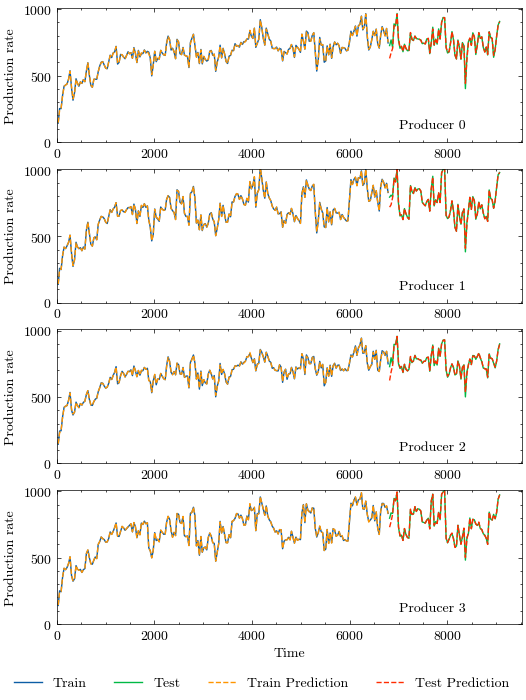

In [14]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharey=True)
for i, p in enumerate(prod):
    axes[i].plot(time_train, prod_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_test[:,p], label=f"Test")
    axes[i].plot(time_train, q_hat_train[:,p], ls="--", label=f"Train Prediction")
    axes[i].plot(time_test, q_hat_test[:,p], ls="--", label=f"Test Prediction")
    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p}", xy=(7000, 100))
axes[i].set(xlabel="Time")
legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4)

0
1
2
3


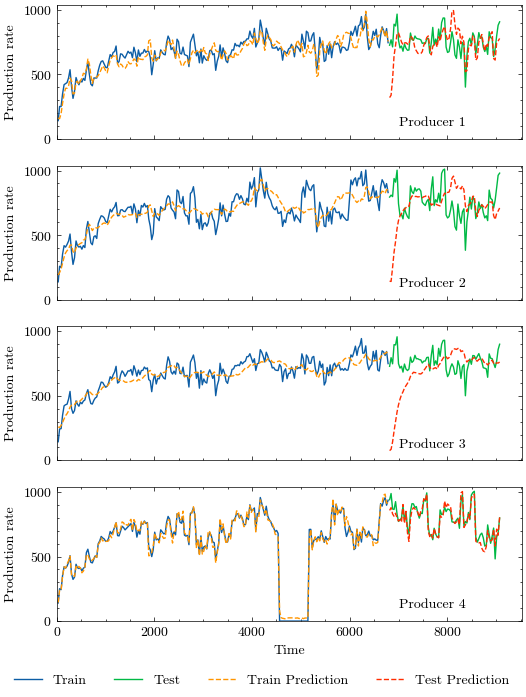

In [21]:
fig, axes = plt.subplots(len(prod.columns), figsize=(6, 8), sharex=True, sharey=True)

for i, p in enumerate(prod):
    print(p)
    #axes[i].plot(time, prod[p], label="Production")
    #axes[i].plot(time, np.array(q_hat)[:, i], ls="--", label="Original Prediction")

    axes[i].plot(time_train, prod_shut_in_train[:,p], label=f"Train")
    axes[i].plot(time_test, prod_shut_in_test[:,p], label=f"Test")
    axes[i].plot(time_train, q_hat_sh_train[:,p], ls="--", label=f"Train Prediction")
    axes[i].plot(time_test, q_hat_sh_test[:,p], ls="--", label=f"Test Prediction")

    axes[i].set(xlim=(0, None), ylim=(0, None), ylabel="Production rate")
    axes[i].annotate(f"Producer {p+1}", xy=(7000, 100))
axes[i].set(xlabel="Time")

legend = axes[i].legend(bbox_to_anchor =(1, -0.3), ncol=4)

fig = plt.show()

In [16]:
connectivity = pd.DataFrame(
    proxy_crm.lambda_ip,
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.33,0.33,0.17,0.17
1,0.33,0.17,0.33,0.17
2,0.25,0.25,0.25,0.25
3,0.17,0.33,0.17,0.33
4,0.17,0.17,0.33,0.33


In [17]:
shut_in_connectivity = pd.DataFrame(
    shut_in_test.lambda_ip,
    index=prod.columns.rename("Producer"),
    columns=inj.columns.rename("Injector"),
)
shut_in_connectivity.T.style.highlight_max(color='blue').format("{:.2}")

Producer,0,1,2,3
Injector,,,,
0,0.68,1.0,0.43,0.037
1,0.64,0.19,1.0,0.0
2,0.046,0.0,0.0,0.32
3,0.0,0.16,0.08,0.34
4,0.0,0.0,0.0,0.47


In [18]:
def rmse(test, pred, test_sh, pred_sh):
  original_rmse = np.sqrt(((test-pred)**2/len(test)).sum())
  shut_in_rmse = np.sqrt(((test_sh-pred_sh)**2/len(test_sh)).sum())
  return original_rmse, shut_in_rmse

result=[]
for j in range(prod.shape[1]):
  result.append(np.array(rmse(prod_test[:,j], q_hat_test[:,j], prod_shut_in_test[:,j], q_hat_sh_test[:,j])))

print(np.array(result))

[[ 17.49179388 115.92046522]
 [ 12.93804739 207.90991254]
 [ 18.45910264 212.33177648]
 [ 11.47936153  39.66118686]]


Trying to use Bayesian + PINN.